In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns

import re
import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
review  = pd.read_csv("yelp_review.csv")

In [6]:
len(review)

5261668

In [9]:
review["date"].max()

'2017-12-11'

In [10]:
review["date"].min()

'2004-07-22'

In [11]:
business.sample(5)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
50357,snIAyWu0r0FBO063SEmi1w,"""Cousins Subs""",NaN,"""10240 N 90th St, Ste 105""",Scottsdale,AZ,85258,33.579384,-111.887160,3.5,30,0,Delis;Sandwiches;Restaurants
156019,y3i9B-h7Hr5iUrLP1xdKzA,"""B & J Body shop""",NaN,"""1512 Nevada Hwy""",Boulder City,NV,89005,35.970137,-114.854306,4.0,5,1,Self Storage;Local Services;Automotive;Body Shops
90365,jCFOGAOzi1n050ISOG9yug,"""Sea Star""",NaN,"""1550 S Gateway Rd""",Mississauga,ON,L4W 5G6,43.632235,-79.614471,4.5,4,1,Chinese;Restaurants
7079,-H16oJ51qutXoarCiupnWQ,"""Cricket Carpet Cleaning""",NaN,"""1208 E Grovers Ave""",Phoenix,AZ,85022,33.627548,-112.059560,4.0,6,1,Shopping;Home & Garden;Local Services;Carpet C...
61998,wP6__WwjrJn_i1PdLLehtw,"""Domino's Pizza""",NaN,"""784 Eglinton Avenue E""",Toronto,ON,M4G 2L1,43.713252,-79.367095,3.0,5,1,Pizza;Restaurants;Italian


In [12]:
### Question 1: What are the most popular words users have written in positive reviews? 

In [13]:
### Question 1 Solution: - Do text analysis on reviews of restaurants whose star is over 3. 
### Use word cloud to present my finding. 

In [14]:
reviews=review[:300,000]
reviews=reviews[reviews.stars>3]

reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [15]:
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords as nltkstopwords

In [16]:
minion=b'iVBORw0KGgoAAAANSUhEUgAAA4QAAAOECAAAAADcJaDnAAAccklEQVR4nO3d2XbbSLJAUfCu/v9f5n2wVZbECVNmRCD2fuiy3TWAQB5GgqSk230BIv1f9AFAdyKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCK8hFv0AXCACCGYCK/AICztf9EHwGESLM4khGAiLM8grM52tJQ/wd0f/uT333Z/9qcV/H04ZY9/F5OwoE+z77bcbuZjHXWfMxv6F9b995/cH/+uilf22eO5PhGW8Wu23X/8wUOVP/40t9uzo69x6OewHa3q54bz+e6zyp709uMvD7++OhEW8ekm73Z79jdVWMq3pcZxjuPV0ct4/jppkX3d7d64RJOwhv0LNPvS/m8rmv1AxzEJK+iwPjs8xhdMwsvLvbpfHl3uwz6VCK+v5nKucS97ChEWcLSimhX24Z4wm4c3rCV0dSZhMl3fsO5MhLn87O52+/gm/Y5/K8nYjmbyGIt8GjAJW9ByZiKEYCJMZOC8MgoTE2EeQmlKhGlosCsRQjARQjARptHoE8v8IMI8hlbojjMvESZiFvYkwkxGVmgUpiXCVNpVmPKgZhNhLnakDfkqCuKYg8uymISdpFvy6Q4oiAiTud/77Ej7PNL3RNhIqZ+XVulYDxJhPgMHRKOVXYgIE2qzI23zQN/z8wmTGjazkl3wN48z2ZGOYxImNWwF1tmR1jnSg0SYVZM50ORhviXCtEYtz2QDRoUibChZhYiQYEahCNMaN7CqjMIqx3mUCLMauQKrfHSmyGEeJUKivXnLvkeFIkyqx/JjWUSY1PD9Yq7Gm782I0Iyy/VkMYgIM5qw9HKt7jd3hbkOdAgR5jNn3TVY3FWIkAxa3xWKMJ2eI6rz2xS+21oy119y/GYSQjARkkPjb3UhwrZsfLMQYS6dy2g7CkWYSucG+xJhJhpsSYR9ST4JEZJG15tCESYyezSlG4VNKxQhyV2/TBGm0eGLdj65fnDPiBCCiRCCiTALm9FlabofFWEObgj/6lihCMmtQZUiJLUGDYoQookQgomQzDrsRkVILh1fJRYhmXRsUIQ5xKy9Fnu9AkRIIi0HoQhTMAhfKHCIJ/AduBPo+fz/6OE89GjQJCSNts9FIiSJxwabDEIRkkTbOeieMIGo1ZdrzjRu0CQM13n1/dP6LIiQBFo3aDsaq/fi+/LiLOTaLw9kEnaVfomnP8DTiDBS4CBMtMSfn4VEBzia7Wgce9FlWZwGEQay+JbFWVgW29E4sasv/WYv/QGeyCSMYQAsy/LmNHRq0CRsKseTgAaXZTEJY+RIgCREGCBDg7f4aZPhNKQgwvksvmVZ3p2G8KeHydwTTpelwSzH8aBbgybhbImW/i1wtSc6DfFMwrksvo/aDUIRdhb3jPDmv9yvQdvRqczBZVmcht9Mwoksvs8aDkKT8DT/FXb/87vH1aRBnop8hewaKqcVcfHfn6+Wy9F29KDKDebTskHb0WMkuNXbM9azQRHupL5dnLZnbEd3sZg4j0m4gwR38qLMUyLcRH4HOHkv2I5uYRkN1HYQmoTrKfAY5+8VEa5g+RznHL4mwo8snxN8PIl9N6Mi/EiCJ3AS3xLha5bOOdacx86D0Kujr2nwHM7jJybhC5YOs4jwCQGex7n8TIQPLJsTrTuZre8I3RM+0uB0zRs0CX8Q4Mmc0DVMwm8smZM5oauYhP+xYs628ox2342K8A8Bvrb75zc5qSvZjja2Kq7b3prWzsH2g1CEy7J4zn7j9t//7PkHWcN2tO9i+TyC/js3W789bd+Tukf7SWi5vDbj3NiMmoS8tD/BDf+kBpfuEbYeg2/X/+8zs3Y/2vqM7tV+O8oze1va+s8ZhMvSfBJ62n5iyi6U7xpHaM08en1O3u9Hd55Lg3BZls7bUQ1u8+Z83TR4SNdJKMEnBew6Kc7kYU0jtHKONnjCGTQI/+q7HeWX2Q3ypeUktIKeTKGPJ+XfSzPO37k6RmgNPVpzTk4+b3ajXxpuRzWYggb/028SanB5KCDgnGjwn24RSnBZfhXglERrth214JbFFMqm2yTkl6CnJc8D37SK0BxcluV7AGEnRIPfddqOavCP28MvZtPgD40i1OCX24+/EG3rd/Apy4rLo8uaW6vLPaEG05Dgb022oxokrxaTUIKJGIQP2twTSjGFPsttg0YRLjoM1mqtbdDknpAENPhCr0m4LItxGKDfItukYYQqnKvhCtuo43bUqpjJ2f6oxVsUxNDfOiJkEAmu1XE76p6QVExCzmcIbtIwQoNwMAlu1C1CBQ6nwa2aRajBsQS4R68INTiUBPdpFKECB9PgTo0iZCABHiBCjpPgIY3erL9bKqTU76so3Bqeqd3yGaFfhIsOz9Jx7YzQaDv6j8VzCqfxJC0n4bIsxuExbZfNCC0n4bIsltERXuM6Vd8IVbibM3euvtvRZVnsSbfrvV7GaB6hDDfpvlgGabwdZSsNjtF+Ei6G4UpWyigmodVFMBEuKlzFSRpGhMtiga3gFI0jQtbQ4EAiXJbFR0CIJMK/VEgUEbKCp6iRRMhnGhxKhF/cFr7kzIwlwn+sNUKIEIKJ8Buj8Bn79NFE+J3lRgAR/qDCB07JcCLkLQ2OJ8KfrLmfnI8JRPiLVfedszGDCH+z7pjMT2XiJc9Hc5iEEEyED7w5/ZfzMIkIeUGDs4jwCctvcRImEiFPaXAe3/z3uebfENiqmMkkhGAifK73KOj96KcT4QvWIbOI8JXGFTZ+6CFE+FLbpdj2gUcRIb9ocDYRvmY1MoUI3/ApUmYQIQQTIT+Z/tOJ8C0bUsYT4QcqZDQRQjDfY+aTe/svqWAwk3AFW1JGEuEaKmQgEa6iQsYR4TptKmzzQBMR4UoWJ6OIcC0VMogIIZgIVzMKGUOE63X4IGmDh5iPCLfokCHTiXAbFXI6EW5kGHI2EW6mQs4lQgjmS5m2uy++uokTmYT72JNyGhHudM0Kr/mosrMd3evPerUt5TCT8JhrvWNxqQdThwiPsnA5yHb0sL8V2piyk0l4FhORnUR4mvoV1n8ENYkQgonwNG4K2UeEZ9EgO4nwJBpkLxFCMO8TnsEY5ACTEIKZhCf4bxDen/0hvHfzBu1RTxP88X8UYSkEEeFYhUK0EqLYjo5131ihr1JsyAszx3zMpcx8KXOg1yPCY05euvch/1ZyE2Em94df0IAIE7k//SVXJ8LBNrzGcn/5Gy5NhGnIrisRZhHcoKeAOCJM4iGCud9MUYOBvFk/1spbwugGov/7vZmEQx366IsymhDhSGsblFtrIoRgIkzg1SCcNiBN4lBemAn3poD7nK+n0GAsk3CgVQXFFxB/BM2ZhMOsG2IKwCSM9anBa/38Q57y7S0GOW8ODr4ttADC2Y4OsDobAbDYjo5QqsEMx9CdSXg236SJjUR4LgmymQhPtaXBDBvBDMeAe8IoGdZ/hmPAJDyTvSh7mITnKdegQZiDSXiaTQ1mWP8ZjoFFhKcZNgbLzVe2sh0NkWEIZTgGlsUkPIk5yH4m4RkqpmIQpmESnmBrgxnWf4Zj4A+T8LiBDQ4bsRpMRISHDdyLVtzmspkIE9NgDyI8anMpGXaCGY6BL16YOWb7sFq//g3CJkzCycwgfhPhISOH1cB/t2eCVGxHDxi6X7QZbcMknMsM4oEI99sxq5I0aMqmYju6156FnOGzMqRjErYk8UxEuFPxZVz88K/FdnSX0Wt4fCO3LPeniHAiq56nbEf32DWosjVoR5qFSbjdVVavHWkSJuEsFjwviHASDfKKCDe7ym50udRDqUyEW+1buNsG4bQ4VJiBCDe62LK92MOpSYTbTFm0M8tQYTwRznDftBud24UKw4lwi9uMG8LZVBhNhOmIohufmNlgyhzUYDsm4XpXbVD2wUS42uVeGP33H5VhKNvRsfLPQcKZhGvN+PIlDbYkwnX27djKNKj+SCIcZ9tb9LElqDCQCIfZ+hZ9bAcqjCPCVep+n1/yE+EYW7ei8aMo+r/f2M0T9mcjfwjh7v/E+SyFICbhCCUbzHEQHXmz/rONi9NAYRuT8KPxDWb52FiSw2hHhJ9MaHD7PzJIlmeDZmxHT7VnK2rhdyfCD7YksutuUIPt2Y6+NX5/lqzBZIfTg0l4kp2viaZb9N44ns8kPMX2D8j8ka7BlId0dSJ8p/7PAt0h5UFdmu3ocTZwHOIW4I1VM2H/Ccw7ciyKqWxHXxscSd4GMx/aFdmOHmJkcJxJeMSBBnN/Qiz1wV2OCF8auhCzr/Lsx3cptqOvfFyG196KesVuHhG+0HoOMpXt6F5H7gfPO4pxct+0XopJuI/NGqcxCZ97Pwb2flR0zb87jyrHWZ5J+IwbwmVZluVm4E9hEu7QYg4yjUm4mQQ5l0n4aODrgtUarHa8NYlwK7dJnMwHIx68ffbvtxe1QIZzT/jbqFJKFsgMtqObNBwLnjyGMwl/+vAm/ah/MZ2ZhBsc+E4WhRssfOhFiPCHcS/KFKbCwWxHv3u33GxFGcQk/GZMg5W3on+UfwDJiXCdK35jw/Wu8BgSE+E/b5Za7wav8iiyck/4Zche1OLlMxH+ZQwSxXZ0WZb3L550fWfiB08nA5mEyzJoiV1r3foq+3FEuAx7exBWsR0d9vbg7n+SZtpOwr4/cmkvX3o6StdJuC6SY9/a8Gou+MSSQ8+nt5XLyduDv7RcLOP12o5ui0ODTNEpwo1taJA52mxHN5ehwSe6rJa5rj8JZzdx5Qa9ZT/E1SPcmYS3B5nnOhHmWP05joJS6keYatmnOpgh2ryIMFH9CM9nmTFV8QiTTZ5khzOEUXi60qd0zJr33sQHlZdMSpUn4ZBFb4UxW+EPcGdrsMsg7PNAZ6m6HR20ELw/uErRRZNV0UmYrkHYrWaEg16RsRddqdejHa5khMleFb3Cd7q/uNzXp+Sro99yOe3s2oluUfWlhJxKTsJvzloMFhVh6j+lnTMLj5yG3HudUSotnNuS+nhLbke/O17A0avTs8FyEo+b6tvR+AbJL/k1Lh5hgimU4BBClHvceQ+49nb08Hk9/hSZ99LyS9oNaelJeDSAE763b+MG6z30rEec9tnhs/gxmPWizlJn7XxdqZxHXHc7eqyAnFeDlspuRw81eMrPmPBZtTq+rnfOS1Z0O3oswfAjuIqki+fbtbn//rOMh1xzO7ryZyqFHwEh7sWuTs1J+PkkD35Yxa7yMFlXz+MsvP36fSYl7wmDE7i5G/xS4ETcvv3vz1+lUTLCT+5+uGdz36//7+ryVVjxnvDTWbQV5bv0F6xghKENpr+gfJTudZB0B7TK6xRMwcnyrp+wRbJZzXvCl2dRg7NVPCXZXlmrOQlfXXvvDAZIu4Li301eqWqEj2fYEAySeAWtumjxx1/whZk/fn4qYvSJlGBJRT46U/OecFn+dXdfRr8gmu0WIpnMJyd+yq1Rdjs6TeY1lkOBJfTuIsYfft1JOIch+FmBU5T7I1Qm4WsFFlcSBRbRm4sZfvQm4UsavJLXpYU3KMJX7EM3cK4OsR19wpraLv86enVV44/cJHykQaYS4QMNXlP8xHul7CdmxhAg85mEEEyE33hFdL/8p+7FESbYpXp19I/8ayi95CtpRYO3oAdhEi7LosEzlDyH97e/ncQLM8tSdP1wrrhF0D5C/fXw8ToHLgTbUVhin4ybT0JzsIlPFzp0ITSOUIAny/tKe+a96GI7yomyPq0lb7BvhN6YHyDnOX13VLdPf8MMPbej0WedaVLfDP7VchJmOPHwpd8kVGAnJa523le0RihxSUpLtZw2X+6go281CTXIG2FPIG0iFOAUiXZWda54gwjrXIwrSFNhoct+/QgLXQzOs/WyRz53XD1CCfZUqcGLv0/oYzHzpTjlpRq8eIQESFHhJtE/LibNffQA9VbDRYSvqU1XPvxoL3tPKMDGql38i25Hq10GOrvkJJQgq8XvRq93TyjABCYtqn/X+v78j1fIsP6vth3VYAZzrsKL/8q2/3iGBXOtCL0vmMSM63BKgykqvMw9YYJzyUw/LviRu6qob37/z1UmoQZ7K339LxJh6WvACSqvgPrb0cpn/7rmv+r+979YcTmUn4QVT3oHQdel5HIo/j5hyXPexOCVdeKlj26g7HZUfr1d6fqXjZDe7j8rPHJDGD0Ii0Z4padBTnD/+suOlRHeYMUXZm4+F1PCxKt0f/KrQgpGCMuP8EqW9025V0dNwUJmvEB6f/JnWyQIoNQ9oQD57r7cDjeUoMFS21EN8svjTnRjVBkaLDQJJchF1YhQgDWlf8Uhx/GV2I5qkCFyNJj/uUqBpQUsr/ULJsvaTxyh+q4gc4VZ1n6Ne0JYr9wXFqa9J/TZNA7JMuZWSBqhBK8i7kLWqTBphHDYx8+UZnmmFyHXVWQY5owwy1MUx4VeyxpfYJHzLQoRXkmGJfZ0RWU4sGVJOgk1yMme9ZalwZwRwnhpGrQdZah7/E96+OvPmspxLL+IkFHSLa2ciz3rdjTpyWKLfBcx3xH9kTNC6su64hNKGqErWJ0ruF7SCKEPEUIwEUIwETKEd5nWyxphjU/ewgmyRkh1RuFqeSM0Cmkib4TQhAghmAghWOII3RTSQ+IIVVibl0fXyhwhtalwpdQRGoW1qXCd1BFCByKEYLkj9AlSGsgdodtCGsgeIVyeCBnHy6OrpI/QbSFXlz5CKjMK1ygQoVFYmApXKBAhXJsIIZgIGcp+9DMRQrAKEXplprKbWfhJhQhVyKWViFCFXFmNCKnMfvQDEUIwETKcUfhekQjdFJamwreKRKhCrqtKhCoszSh8p0yElKbCN+pE6Kt7S1Pha3UitCPloipFCJdUKkKjsDD70ZdKRahCrqhWhCoszCh8pViEKixMhS9Ui9A7FVxOuQipyyh8rmCERiHXUjBCFXItFSNUYVW+6dNT/4s+gMn+9msxkEfJSbjf/ddfIV7NCPc2pL1otiBP3Kquyx1X8+dDtRxCVF1vI9WchCs8vKn/+w+shhBem3l01QjvKqOKsq+O3l9vKP+9+nL7/UeQT9l7wmV5VeH919/y+hHaGYWovOSGKL0dfXo1f9/6vbnkVkMIz32/lN2OLsvyY8P557dP/g5IrvQkXH4Ouu3BSTSEUfhT9QihvNIvzHy5LfuHmmflAFdYdCeqfU/4l2tKZbajEKx9hL5nDdHaR2gzSzQRQjAR2pESTIQQTITL4raQUCJclkWFRBLhHyqcyMn+SYR/WRhEESGzeb77RYRfvFExifP8mwghmAj/8RRNCBF+o0IiiPA7FRJAhD+ocDSvfz0S4U/WyFhO7xMihGAi/M1z9Tj2GU+J8IGVwlwiZBrPbs+J8AmLZQin9QURPmO5DOCkviLCpywY5hHhcyo8mzP6kghfsGZO5SXnN0T4ilXDJJf4qUyD+IFNJ7HG3jMJX7OFOofT+IEIGUyDn9iOvmVHepDltYIIP5DhARbXKrajH1hHjGYSfmQW7mJhrSbCFWS4mWW1ge0oBDMJVzELn7kvy9NTY01tYxKuYlk98eekPH6kwcnaSITrWFgP7g+/ePpbPvpf9AFUcbcl/eF5agLcQ4Sr3VX4HwmeyXZ0PWvsy/MNqPOzk1dHNzEMpXY+k3ATX93U/gQMIEK20OAAtqPbdd2TWiqDmISspMFRRLhdz9XY81FPYTu6S7cdqVUykkm4S69F6TXhsUS4j2XJaWxHd2uyJbVAhjMJd+uxOns8ylgi3K/D+uzwGMPZjh5z6T2ptTGHScgrGpxEhMd49Z7DbEdPcMU9qXUxjwjPcLUKLYqpbEchmEl4lstMQytiNhGe5xIZWg/z2Y6e5wrr9wqPoRyT8GSFx6GlEMQkPFnZlewdzzAiPJvFzEa2o4NU2pZaA7FEOEyVDK2AaLajwxRZ3EUO88pMwuHSTkSXPgkRzpCxQxc+DRHOkS1Dlz0REU4WXaPrnY8IZwus0LXOyaujs8WVoMGk/LjsDuSXmgivT4LJ2Y5engazMwmvTH8lmISzTXx1VIM1iBCCiXAyg5DfRDiXBnkgQggmQggmwquyGy1DhBBMhBBMhFNFfzUhGYkQgokQgolwJrtRnhAhBBPhRAYhz4gQgokQgokQgokQgonwonx+uw4RQjARzuMdCp4S4TXZjRYiQggmQggmQggmwktyS1iJCCGYCCGYCKfxNiHPiRCCiRCCiXAWu1FeEGER3nS4LhHWcFfhdYmwgvt9MQuvS4QFyO/aRJjf/ddfuRgRpqe9qxNhdhq8PBEmd3/xa65DhLnprgERpnZ/+1uuQYQQTISZmXwtiDAxDfYgwrw02IQI03rW4F2YFyRCCCbCSc76ml6j8Hr+F30APCe2PkxCCCbCnF4PQiPyckRYzooKhVqKCOfY9rrM+3ciJHYxIrwgldYiwoRE1IsIpzj3O/+K9FpEmM/nxlR4Kd6sz0Zg7ZiEEEyEEEyEyZywG7WhLUaEuQioIRGmosGORAjBRJiJQdiSCGdY+YEZDfYkwjw02JQIJzj3k6Mj/oVEEuF4GuQtEaZhN9qVCLPQYFsiTEKDfYkQgvl6whTMwc5MwuG8lsl7IszAIGxNhKOtGIQa7E2Eg2mQT0QYToPdiRCCiRCCeZ8wmM0oJuFY3iTkIxEO9bFBgxARDmUOsoIIIZgIC7KHvRYRhtqZkwovRYQDjXtZRoVXIsJxgl6WEWg1Igx0IJfX/6gGyxHhMGMHodauQ4RVqfAyRHgx2qzHB7hHGf6JtbsP5FyECMfQB6uJMMo5P5xe7BfgnrC2Xynf3RIWJMIh5g2o+8vfUIXt6AgzN4nCK88kHGBNg9rhiwjPp0E2EeHpvGDJNiI826oGDUL+EeHJzEG2EiEE8xbFqcxBthPhKcTHfrajZ9AgB5iEhymQY0R4iAA5znYUgpmEB5iDnEGEeymQk9iORvCpNb4RYQAN8p3t6D42o5zGJNxFg5xHhBBMhPO5JeQHEUIwEe7hlpATiRCCiRCCiRCCiXA6L47ykwhn0yC/iHAyDfKbCCGYCPcwzjiRCCGYCCGYCOeykeWBCKfSII9ECMFEuMvdSOM0ItxJhZxFhDMplydEuJcdKScR4X4q5BQihGAiPMCOlDOI8BAVcpwIj1Ehh4nwIFtSjhIhBBPhYUYhx4jwODtSDhEhBBPhGYxCDhDhKVTIfiI8hwrZTYQQTIQnMQrZS4RnWVOhHy7KEyI8jVnIPiI8z4oKjUIeifBEKmQPEZ7JjpQdRHgqFbKdCM/1sUL7UX4T4Wwq5BcRnuzzhlSF/CTCs/nqQjYS4Xw3s5DvRHg+O1I2EeEANqRsIcIRvFHBBjfP2oN86Mx554tJOMqHysxCvogwigr563/RB3Bdd6GxikkYxtuF/CHCkbz6wgoiHMpn2PhMhIOpkE9EOJoK+UCEw9mS8p4IJ5Ah74gQgvns6DQPbws69SzLYhJO9HtTqkH+EOFE95e/oTPbUQhmEkIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUKw/wf0n8IA+qpuMAAAAABJRU5ErkJggg=='

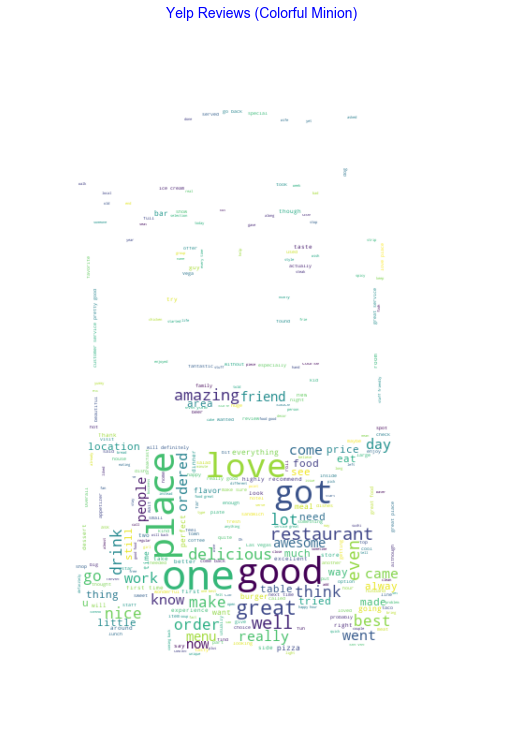

In [17]:
import imageio
import codecs
from wordcloud import WordCloud, STOPWORDS
f2 = open("minion", "wb")
f2.write(codecs.decode(minion,'base64'))
f2.close()
img2 = imageio.imread("minion.jpg")
minion_mask = img2

wc = WordCloud(background_color="white", max_words=5000, mask=minion_mask,
               stopwords=STOPWORDS)
# generate word cloud
texts = reviews["text"].values
wc.generate(" ".join(texts[:40000]))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Yelp Reviews (Colorful Minion)", fontsize=14,color='blue')
plt.axis("off");

In [18]:
### Question1 Findings: most popular words users have written in positive review are food, place , 
### great, love, got etc.

In [19]:
### Question 2: What are the 10 most frequent part of speech tags in the review text?

In [20]:
### A new map reduce task was created to compute the number of part of speech in the entire text.
### The text was normalized to remove all the ',' and '.' using the regex expression.The normalized text was 
### tokenized and mapped later was reduced based on the POS tag as the key.The ten most common tag was collected
### from the RDD and a DataFrame was created to plot the bar plot of their frequency using the Seaborn Barplot.

In [21]:
def normalize_and_extract_Pos(line):
    sample=[] 
    line=line.lower()
    line=re.sub(r"\,|\.","",line)
    z=nltk.word_tokenize(line)
    z=nltk.pos_tag(z)
    for i in z:
        
        sample.append(i[1])
        
    return sample

In [55]:
thefile = open('Output.txt', 'w')
for item in reviews["text"]:
  thefile.write("%s\n" % item)

In [22]:
input_text = sc.textFile("Output.txt")

In [23]:
POS = input_text.flatMap(normalize_and_extract_Pos)

POS1=POS.map(lambda x:(x,1))
POS2=POS1.reduceByKey(lambda x,y:x+y)
POS_sorted=POS2.sortBy(lambda x: x[1], ascending = False)
POS_sorted.take(10)

[('NN', 658184),
 ('JJ', 317993),
 ('DT', 296013),
 ('IN', 290636),
 ('RB', 222224),
 ('VBD', 156687),
 ('PRP', 150869),
 ('CC', 142224),
 ('NNS', 132459),
 ('VB', 120244)]

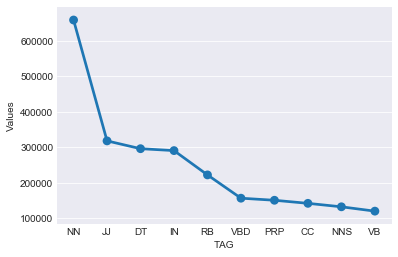

In [25]:
sns.set_style("darkgrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(x=datas['TAG'],y=datas['Values'], data=datas)

In [22]:
### Question2 Findings: The 10 most frequent part of speech tags in the review text are: NN, JJ, DT, IN, RB, VBD, PRP,
### CC, NNS, VB. 

In [23]:
### Question 3: Some reviews are tagged as useful, funny or cool. Is there a correlation between useful and stars, 
### funny and stars, and cool and stars? If a review is tagged as useful, is it more like to be tagged as funny or 
### cool?

In [58]:
nan_rows_useful = review[review['useful'].isnull()]
nan_rows_useful

,review_id,user_id,business_id,stars,date,text,useful,funny,cool


In [59]:
nan_rows_funny = review[review['funny'].isnull()]
nan_rows_funny

,review_id,user_id,business_id,stars,date,text,useful,funny,cool


In [61]:
nan_rows_cool = review[review['cool'].isnull()]
nan_rows_cool

,review_id,user_id,business_id,stars,date,text,useful,funny,cool


In [60]:
useful_stars = review.stars.corr(review['useful'])
useful_stars

-0.07712237031012746

In [28]:
funny_stars = review.stars.corr(review['funny'])
funny_stars

-0.04886623628373971

In [29]:
cool_stars = review.stars.corr(review['cool'])
cool_stars

0.04482794956261903

In [30]:
useful_funny = review.useful.corr(review['funny'])
useful_funny

0.6216627336749847

In [31]:
useful_cool = review.useful.corr(review['cool'])
useful_cool 

0.6770692869472497

In [32]:
funny_cool = review.funny.corr(review['cool'])
funny_cool

0.6616694021074953

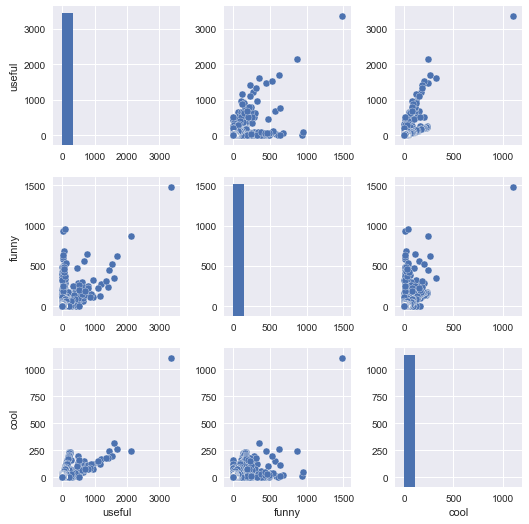

In [33]:
sns.pairplot(review[['useful','funny','cool']])

In [34]:
### Question3 Findings: 1. There is no correlation between useful and stars, funny and stars, and cool and stars since their 
### correlation coefficient are smaller than 0.1. 

### 2. There is a positive moderate correlation between useful and funny, funny and cool and useful and cool. Therefore, 
### if a review is tagged as useful, it is more like to be tagged as funny or cool. If a review is tagged as funny, it is more 
### likely to be tagged as cool. 

In [35]:
### Question 4: Can we predict whether a review is positive or negative by analyzing yelp review “text” column? 

In [78]:
from gensim import corpora, models, similarities

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist

import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv("yelp_review.csv")

In [63]:
# for efficiency, only using 4000 samples for this project
data = df.sample(4000)

In [79]:
# some features for reviews:
length = []       # length of the review
word_count = []   # number of words in the review
text_array = []   # storing words in reviews after removing stop words and stemming in array

# some other possible features: has_poswords and has_negwords
# those are some of the most frequent words in positive reviews and are not frequent
# in negative reviews. After verifying, among all reviews containing one of these words,
# around 80% of them are positive reviews
poswords = ["great", "delicious", "love", "friendly", "best", "amazing"]
has_poswords = []
# similarly, those are some of the most frequent words in negative reviews and are not 
# frequent in positive reviews.
negwords = ["bad", "never", "wait"]
has_negwords = []

# classification for reviews:
# if a review has more than 3 stars, then it's classified as positive,
# otherwise, it's classified as negative
is_positive = [1 if x > 3 else 0 for x in data['stars']]

# stop words and stemmer defined by the nltk package
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

# FreqDist() for counting most frequent words in positive and negative reviews
pos_fdist = FreqDist()
neg_fdist = FreqDist()

In [80]:
# Prepare input features for the given dataset
for stars, text in zip(data.stars, data.text):
    
    text = text.lower()
    
    # length:
    length.append(len(text))
    
    # check whether this review has predefined positive or negative words
    if sum([1 if x in text else 0 for x in poswords]) > 0:
        has_poswords.append(1)
    else:
        has_poswords.append(0)
        
    if sum([1 if x in text else 0 for x in negwords]) > 0:
        has_negwords.append(1)
    else:
        has_negwords.append(0)
    
    # word_count:
    word_count.append(len(word_tokenize(text)))   
    
    # remove stop words and stemming for text_array
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    words = word_tokenize(text)
    words_filtered = [w for w in words if not w in stop_words]
    
    # for checking most frequent words in positive and negative reviews
    if stars > 3:
        for word in words_filtered:
            pos_fdist[word] += 1
    else:
        for word in words_filtered:
            neg_fdist[word] += 1
    
    # stemming
    for i in range(len(words_filtered)):
        words_filtered[i] = stemmer.stem(words_filtered[i])
        
    text_array.append(words_filtered)

In [40]:
# Prepare those features for the given dataset
for stars, text in zip(data.stars, data.text):
    
    # get text of review, convert to lowercase
    tmp_text = text.lower()
    
    # length:
    length.append(len(tmp_text))
    
    # has_poswords:
    if sum([1 if x in tmp_text else 0 for x in poswords]) > 0:
        has_poswords.append(1)
    else:
        has_poswords.append(0)
    
    # word_count:
    # define a regex for tokenenize tmp_text into array of words
    pattern = r'''(?x)           # set flag to allow verbose regexps
    (?:[A-Z']\.)+(?:'\w*)?       # abbreviations, e.g. U.S.A.
    | \w+(?:[-']\w+)*            # words with optional internal hyphens
    | \$?\d+(?:\.\d+)?%?         # currency and percentages, e.g. $12.40, 82%
    '''
    word_count.append(len(regexp_tokenize(tmp_text, pattern)))
    
    # flesch_score and flesch_kincaid_score:
    if len(tmp_text.strip()) > 0:
        flesch_score.append(flesch(tmp_text))
        flesch_kincaid_score.append(flesch_kincaid(tmp_text))
    else:
        flesch_score.append(206.835)
        flesch_kincaid_score.append(-15.59)
    
    
    # NLP preprocess for Dictionary construction:
    # remove stop words
    # replace punctuations by space in tmp_text
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    tmp_text = tmp_text.translate(replace_punctuation)
    words = word_tokenize(tmp_text)
    words_filtered = [w for w in words if not w in stop_words]
    
    # get frequencies of words after removing stop words for positive and negative reviews separately
    if stars > 3:
        for word in words_filtered:
            pos_fdist[word] += 1
    else:
        for word in words_filtered:
            neg_fdist[word] += 1
    
    # stemming
    for i in range(len(words_filtered)):
        words_filtered[i] = stemmer.stem(words_filtered[i])
    
    # text_space for similarity measures for reviews for the same business
    text_space.append(words_filtered)

In [81]:
data.index = data.review_id
# add the features extracted to data
data['length'] = length
data['word_count'] = word_count
data['has_poswords'] = has_poswords
data['has_negwords'] = has_negwords

data['text_array'] = text_array

data['is_positive'] = is_positive


data['avg_sim'] = 0.0  # the average similarity measure between a review and other reviews for the same business using the gensim package

In [82]:
# positive reviews for the same business might have more similar contents 
# https://radimrehurek.com/gensim/tut2.html
for bus_id in np.unique(data.business_id):
    
    # get all reviews for this business
    review_data = data.loc[(data.business_id == bus_id)]
    
    # construct a dictionary using the words in reviews for the current business for similarity measures
    dictionary = corpora.Dictionary(review_data.text_array)
    
    if len(dictionary.token2id) > 0:
        corpus = [dictionary.doc2bow(rev) for rev in review_data.text_array]
        
        lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)
        index = similarities.MatrixSimilarity(lsi[corpus])
        
        for rev_id, rev in zip(review_data.review_id, review_data.text_array):
            rev_vec = dictionary.doc2bow(rev)
            sims = index[lsi[rev_vec]]
            
            sims = sorted(enumerate(sims), key=lambda item: -item[1])
            sims_new = [x[1] for x in sims[1:]]
            
            if len(sims_new) > 0:
                data.at[(rev_id, "avg_sim")] = np.mean(sims_new)

In [43]:
# random split for train-test
train, test = train_test_split(data, test_size=0.2)

# exclude the following columns that are not needed for the model
excludes = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'text_array', 'is_positive']
X_train = train.drop(excludes, axis=1)
y_train = train.is_positive

X_test = test.drop(excludes, axis=1)
y_test = test.is_positive

In [69]:
# helper method for plotting validation curve for a given model and given parameters
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
def plot_validation_curve(estimator, title, X, y, param_name, param_range):

    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name,
                                                 param_range=param_range, cv=10,
                                                 scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    lw = 2
   
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
 
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

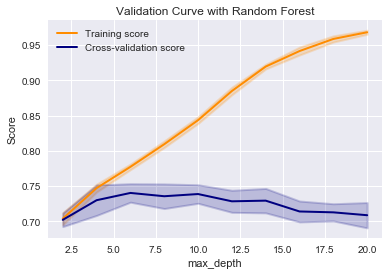

In [70]:
# 10-fold cross-validation to get the best max_depth
param_range = [i for i in range(2, 21) if i % 2 == 0]
title = "Validation Curve with Random Forest"
plot_validation_curve(RandomForestClassifier(), title, X_train, y_train, "max_depth", param_range)
plt.show()

In [83]:
# from validation above, max_depth=4 gives best score
# Random Forest Classifier    
rf_model = RandomForestClassifier(max_depth=4, random_state=0)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

accuracy = 0
for y_pred, y in zip(rf_pred, y_test):
    if y_pred == y:
        accuracy += 1
print("Accuracy: " + str(accuracy/len(y_test)))

Accuracy: 0.735


In [84]:
# From validation above, max_depth=8 gives best score
# Random Forest Classifier    
rf_model = RandomForestClassifier(max_depth=8, random_state=0)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

accuracy = 0
for y_pred, y in zip(rf_pred, y_test):
    if y_pred == y:
        accuracy += 1
print("Accuracy for Random Forest Classifier: " + str(accuracy/len(y_test)))

Accuracy for Random Forest Classifier: 0.7575


useful :  0.07749256852230708
funny :  0.061123270353326466
cool :  0.0727686930628038
length :  0.1776307351216409
word_count :  0.1457190014735451
has_poswords :  0.324044727367924
has_negwords :  0.08821781312221885
avg_sim :  0.053003190976233794


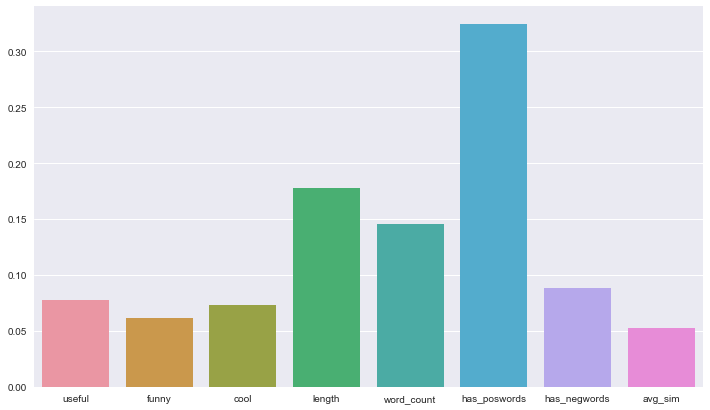

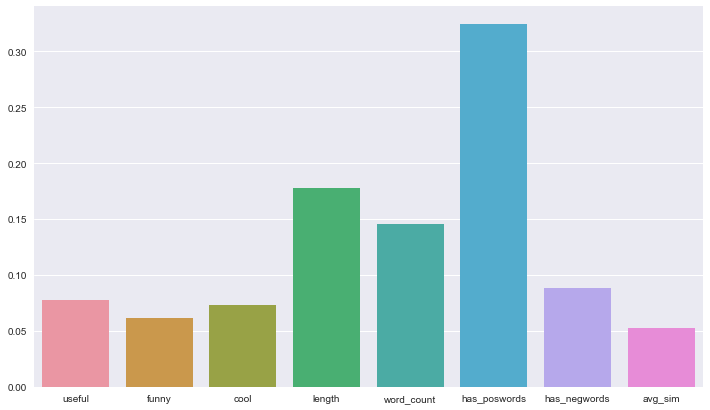

In [85]:
for feature, importance in zip(X_train.columns, rf_model.feature_importances_):
    print(feature, ": ", importance)

f, ax = plt.subplots(figsize=(12, 7))
sns.set(style="darkgrid")
sns.barplot(x=X_train.columns, y=rf_model.feature_importances_)
display(f)

In [86]:
print(len(train)) # number of training data
print(len(np.unique(train.business_id))) # number of unique businesses
print(len(train)/len(np.unique(train.business_id))) # average number of reviews for each business

3200
2942
1.087695445275323


In [87]:
pos_fdist.most_common(10) # most common words in positive reviews

[('great', 1471),
 ('place', 1336),
 ('good', 1306),
 ('food', 1245),
 ('service', 877),
 ('time', 835),
 ('like', 809),
 ('one', 752),
 ('get', 715),
 ('really', 710)]

In [88]:
neg_fdist.most_common(10) # most common words in negative reviews

[('food', 807),
 ('good', 656),
 ('place', 655),
 ('get', 590),
 ('like', 582),
 ('service', 578),
 ('would', 573),
 ('time', 538),
 ('one', 528),
 ('back', 508)]

In [89]:
### Question4 Findings: the most reasonable feature importance is has_poswords. The accuracy of random forest 
### classifier is 0.71. 